<a href="https://colab.research.google.com/github/dungruoc/DeepLearning-Pytorch/blob/main/SpatialTransformerNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

In [8]:
# Training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))

In [9]:
device = torch.device('cuda')

In [10]:
class View(nn.Module):
    def __init__(self, a, b):
        super().__init__()
        self.a = a
        self.b = b

    def forward(self, x):
        return x.view(self.a, self.b)

class CnnClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(1, 10, kernel_size=5),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True),
        nn.Conv2d(10, 20, kernel_size=5),
        nn.Dropout2d(),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True),
        View(-1, 320),
        nn.Linear(320, 50),
        nn.ReLU(True),
        nn.Dropout1d(),
        nn.Linear(50, 10),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    return self.model(x)

class STN(nn.Module):
  def __init__(self):
    super().__init__()
    self.localization = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=7),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True),
        nn.Conv2d(8, 10, kernel_size=5),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True)
    )
    
    self.fc_loc = nn.Sequential(
        nn.Linear(10 * 3 * 3, 32),
        nn.ReLU(True),
        nn.Linear(32, 3 * 2)
    )
    
    self.fc_loc[2].weight.data.zero_()
    self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0]))
  
  def forward(self, x):
    xs = self.localization(x)
    xs = xs.view(-1, 10 * 3 * 3)
    theta = self.fc_loc(xs)
    theta = theta.view(-1, 2, 3)
    
    grid = F.affine_grid(theta, x.size())
    return F.grid_sample(x, grid)

In [24]:
def train(epoch, model, device, data_set):
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    train_loader = torch.utils.data.DataLoader(data_set, batch_size=64,
                                               shuffle=True, num_workers=4)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#

def test(model, device, data_set):
    test_loader = torch.utils.data.DataLoader(data_set, batch_size=64,
                                              shuffle=False, num_workers=4)
    corrects = []
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            matched = pred.eq(target.view_as(pred))
            corrects += list(map(lambda x: x.item(), matched))
            correct += matched.sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
    return corrects

In [12]:
cnn_classifier = CnnClassifier().to(device)

In [13]:
for epoch in range(1, 20 + 1):
    train(epoch, cnn_classifier, device, train_dataset)
    test(cnn_classifier, device, test_dataset)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310389
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.546488


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.4232, Accuracy: 9250/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.271231
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.370918

Test set: Average loss: 0.2994, Accuracy: 9476/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.482261
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.462957

Test set: Average loss: 0.2397, Accuracy: 9574/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.463776
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.247607

Test set: Average loss: 0.2061, Accuracy: 9677/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.276896
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.210063

Test set: Average loss: 0.1904, Accuracy: 9696/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.009757
Train Epoch: 6 [32000/60000 (53%)]	Loss: 1.344392

Test set: Average loss: 0.1694, Accuracy: 9727/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.262720
Train Epoch: 7 [32000/60000 (53%)]	Loss: 1.217928

Test set: Average loss: 0.1610, Accuracy: 9730/10000 (97%)

Tra

In [25]:
corrects = test(cnn_classifier, device, train_dataset)
corrects[:3]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0921, Accuracy: 59091/60000 (98%)



[True, True, True]

In [26]:
corrects.count(True)

59091

In [27]:
bad_dataset = torch.utils.data.Subset(train_dataset, np.where(np.array(corrects) == False)[0])
len(bad_dataset)

909

In [28]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn(stn_model, data_set):
    test_loader = torch.utils.data.DataLoader(data_set, batch_size=64,
                                              shuffle=False, num_workers=4)
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        if stn_model:
          transformed_input_tensor = stn_model(data).cpu()
        else:
          transformed_input_tensor = data.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


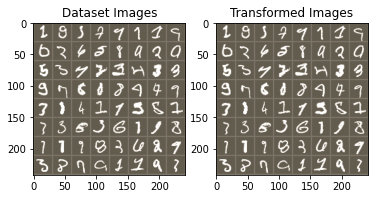

In [29]:
visualize_stn(None, bad_dataset)

In [30]:
cnn_classifier2 = CnnClassifier().to(device)
good_dataset = torch.utils.data.Subset(train_dataset, np.where(np.array(corrects) == True)[0])
for epoch in range(1, 20 + 1):
    train(epoch, cnn_classifier2, device, good_dataset)
    test(cnn_classifier2, device, test_dataset)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch: 1 [0/59091 (0%)]	Loss: 2.289917
Train Epoch: 1 [32000/59091 (54%)]	Loss: 1.310391


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.4259, Accuracy: 9224/10000 (92%)

Train Epoch: 2 [0/59091 (0%)]	Loss: 1.475524
Train Epoch: 2 [32000/59091 (54%)]	Loss: 1.191780

Test set: Average loss: 0.2885, Accuracy: 9438/10000 (94%)

Train Epoch: 3 [0/59091 (0%)]	Loss: 1.396366
Train Epoch: 3 [32000/59091 (54%)]	Loss: 1.244087

Test set: Average loss: 0.2034, Accuracy: 9607/10000 (96%)

Train Epoch: 4 [0/59091 (0%)]	Loss: 1.104751
Train Epoch: 4 [32000/59091 (54%)]	Loss: 1.316723

Test set: Average loss: 0.1653, Accuracy: 9660/10000 (97%)

Train Epoch: 5 [0/59091 (0%)]	Loss: 1.382915
Train Epoch: 5 [32000/59091 (54%)]	Loss: 1.107933

Test set: Average loss: 0.1464, Accuracy: 9700/10000 (97%)

Train Epoch: 6 [0/59091 (0%)]	Loss: 1.058923
Train Epoch: 6 [32000/59091 (54%)]	Loss: 1.310118

Test set: Average loss: 0.1942, Accuracy: 9460/10000 (95%)

Train Epoch: 7 [0/59091 (0%)]	Loss: 1.178506
Train Epoch: 7 [32000/59091 (54%)]	Loss: 1.225809

Test set: Average loss: 0.1205, Accuracy: 9741/10000 (97%)

Tra

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [32]:
correct2 = test(cnn_classifier2, device, good_dataset)


Test set: Average loss: 0.0435, Accuracy: 58711/59091 (99%)



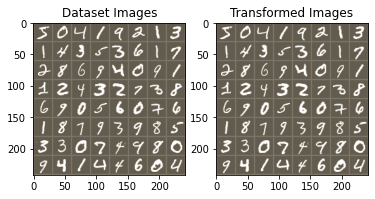

In [33]:
visualize_stn(None, torch.utils.data.Subset(good_dataset, np.where(np.array(correct2) == True)[0]))

In [34]:
import copy
cnn_state = copy.deepcopy(cnn_classifier2.state_dict())

stn_model = nn.Sequential(
    STN(),
    CnnClassifier()
)

stn_model[1].load_state_dict(cnn_state)
for param in stn_model[1].parameters():
    param.requires_grad = False

stn_model = stn_model.to(device)

In [35]:
for epoch in range(1, 20 + 1):
    train(epoch, stn_model, device, train_dataset)
    test(stn_model, device, test_dataset)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.195482
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.265868


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0740, Accuracy: 9833/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.237864
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.481025

Test set: Average loss: 0.0686, Accuracy: 9832/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.102706
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.154173

Test set: Average loss: 0.0643, Accuracy: 9847/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.138846
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.282500

Test set: Average loss: 0.0821, Accuracy: 9802/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.156298
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.096433

Test set: Average loss: 0.0627, Accuracy: 9857/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.088551
Train Epoch: 6 [32000/60000 (53%)]	Loss: 1.158928

Test set: Average loss: 0.0765, Accuracy: 9825/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.495335
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.839374

Test set: Average loss: 0.0598, Accuracy: 9863/10000 (99%)

Tra

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.0582, Accuracy: 225/909 (25%)



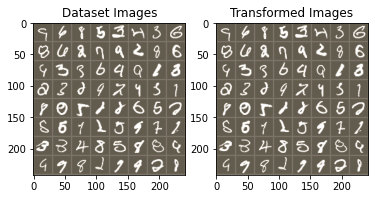

In [36]:
classifier2_badset = test(cnn_classifier2, device, bad_dataset)
visualize_stn(None, torch.utils.data.Subset(bad_dataset, np.where(np.array(classifier2_badset) == True)[0]))

In [39]:
stn_badset = test(stn_model, device, bad_dataset)
stn_badset.count(True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali


Test set: Average loss: 1.4866, Accuracy: 387/909 (43%)



387

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

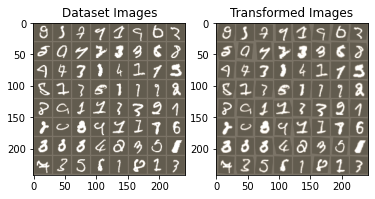

In [41]:
visualize_stn(stn_model[0], torch.utils.data.Subset(bad_dataset, np.where(np.array(stn_badset) == False)[0]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310001
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.281871


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.4375, Accuracy: 9114/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.444439
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.219305

Test set: Average loss: 0.2075, Accuracy: 9652/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.079754
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.253421

Test set: Average loss: 0.1831, Accuracy: 9673/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.014936
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.176940

Test set: Average loss: 0.1411, Accuracy: 9723/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.305219
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.286414

Test set: Average loss: 0.1178, Accuracy: 9781/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.095012
Train Epoch: 6 [32000/60000 (53%)]	Loss: 1.197723

Test set: Average loss: 0.1192, Accuracy: 9767/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.181230
Train Epoch: 7 [32000/60000 (53%)]	Loss: 1.126355

Test set: Average loss: 0.1195, Accuracy: 9808/10000 (98%)

Tra

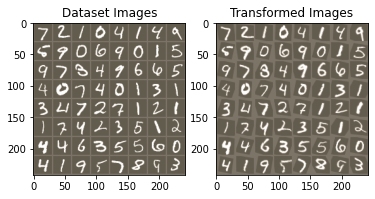

In [42]:
stn_model2 = nn.Sequential(
    STN(),
    CnnClassifier()
)

stn_model2 = stn_model2.to(device)

for epoch in range(1, 40 + 1):
    train(epoch, stn_model2, device, train_dataset)
    test(stn_model2, device, test_dataset)

visualize_stn(stn_model2[0], test_dataset)

plt.ioff()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

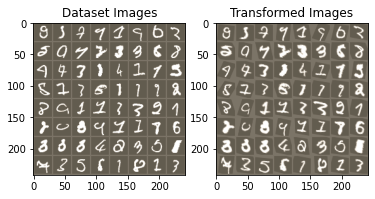

In [43]:
visualize_stn(stn_model2[0], torch.utils.data.Subset(bad_dataset, np.where(np.array(stn_badset) == False)[0]))